In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# p.176 必要なライブラリをインポートする
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# p.178 ランダムシードの設定
import random
np.random.seed(1234)
random.seed(1234)

# p.184 LabelEncoderのライブラリをインポート
from sklearn.preprocessing import LabelEncoder

# p.188 LightGBMのライブラリをインポート
import lightgbm as lgb

# リスト4.17 LightGBMのハイパーパラメータを設定
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}

# p.189 クロスバリデーション用のライブラリを読み込んで分割数を3に設定
from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

# p.190 リスト4.19 平均二乗誤差を出すライブラリをインポート
from sklearn.metrics import mean_squared_error

# p.234 リスト4.65 Optunaのライブラリのインポート
import optuna

# p.235 リスト4.66 学習データと検証データを作成
from sklearn.model_selection import train_test_split

# p.245 リスト4.76 ランダムフォレスト用のライブラリの読み込み
from sklearn.ensemble import RandomForestRegressor as rf

# p.251 リスト4.84 XGBoostのライブラリのインポート
import xgboost as xgb

# p.279 決定木を可視化するためのライブラリをインストールする
!pip install pydotplus

# p.281 リスト4.115 ライブラリのインポート
from sklearn import tree
import pydotplus
from six import StringIO

     |████████████████████████████████| 278 kB 922 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=111f6ebd48c3a7578cdfa806ecd57f3191f656683b1e4daecc4ef9c9d0d80485
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


In [2]:
# p.179 CSVデータを読み込む
train_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

# train_df.head()

# p.180 学習データの各変数の型を確認する
# train_df.dtypes

# p.181 MSZoningの各分類ごとの個数を確認する
# train_df["MSZoning"].value_counts()

# p.182 学習データとテストデータの連結
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
# all_df

# p.183 目的変数であるSalePriceの値を確認
# all_df["SalePrice"]

# object型の変数を取得
categories = all_df.columns[all_df.dtypes == "object"]
# print(categories)

# p.185 'Alley'の各分類の個数を確認
# all_df["Alley"].value_counts()

# 欠損値を数値に変換する
for cat in categories:
    le = LabelEncoder()
    # print(cat)
    all_df[cat].fillna("missing", inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")
# all_df

# p.188 データをtrain_dfとtest_dfに戻す
#train_df_le = all_df[~all_df["SalePrice"].isnull()]
#test_df_le = all_df[all_df["SalePrice"].isnull()]
# train_df_le.head()
# test_df_le.head()

# リスト4.18 説明変数、目的変数を指定
#train_X = train_df_le.drop(["SalePrice", "Id"], axis=1)
#train_Y = train_df_le["SalePrice"]

# p.190 リスト4.20 各foldごとに作成したモデルごとの予測値を保存
#models = []
#rmses = []
#oof = np.zeros(len(train_X))

#for train_index, val_index in kf.split(train_X):
#    X_train = train_X.iloc[train_index]
#    X_valid = train_X.iloc[val_index]
#    y_train = train_Y.iloc[train_index]
#    y_valid = train_Y.iloc[val_index]
    
#    lgb_train = lgb.Dataset(X_train, y_train)
#    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
#    model_lgb = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=100, early_stopping_rounds=20, verbose_eval=10,)
    
#    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
#    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
#    print(tmp_rmse)
    
#    models.append(model_lgb)
#    rmses.append(tmp_rmse)
#    oof[val_index] = y_pred
    
# p.192 平均RMSEを計算する
# sum(rmses)/len(rmses)

# p.193 statisticsライブラリから計算
#from statistics import mean
#mean(rmses)

# p.193 現状の予測値と実際の値の違いを可視化
#actual_pred_df = pd.DataFrame({"actual": train_Y, "pred": oof})
#actual_pred_df.plot(figsize=(12,5))

# p.194 各変数の重要度を確認する
# リスト4.24 変数の数を制限して各変数の重要度を表示
#for model in models:
#    lgb.plot_importance(model, importance_type="gain", max_num_features=15)

# p.197 リスト4.25 SalePriceの各統計量を確認する
#train_df["SalePrice"].describe()

# p.198 リスト4.26 ヒストグラムで分布を確認
#train_df["SalePrice"].plot.hist(bins=20)

# p.199 リスト4.27 SalePriceを対数化
#np.log(train_df['SalePrice'])

# 対数化したSalePriceの分布をヒストグラムで可視化
#np.log(train_df['SalePrice']).plot.hist(bins=20)

# p.200 リスト4.29 対数化による予測精度の向上を確認
#train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
#train_X = train_df_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
#train_Y = train_df_le["SalePrice_log"]

#models = []
#rmses = []
#oof = np.zeros(len(train_X))

#for train_index, val_index in kf.split(train_X):
#    X_train = train_X.iloc[train_index]
#    X_valid = train_X.iloc[val_index]
#    y_train = train_Y.iloc[train_index]
#    y_valid = train_Y.iloc[val_index]
    
#    lgb_train = lgb.Dataset(X_train, y_train)
#    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
#    model_lgb = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=100, early_stopping_rounds=20, verbose_eval=10,)
    
#    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
#    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
#    print(tmp_rmse)
    
#    models.append(model_lgb)
#    rmses.append(tmp_rmse)
#    oof[val_index] = y_pred
    
#sum(rmses)/len(rmses)

# p.204 リスト4.30 all_dfの作成
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
categories = all_df.columns[all_df.dtypes == "object"]
#print(categories)

# p.205 リスト4.31 欠損値の数が上位40の変数を確認
#all_df.isnull().sum().sort_values(ascending=False).head(40)

# p.207 リスト4.32 PoolQCの各分類ごとの個数
#all_df.PoolQC.value_counts()

# リスト4.33 PoolQCの値を値があるものを1、値がないものを0に変換
#all_df.loc[~all_df["PoolQC"].isnull(), "PoolQC"] = 1
#all_df.loc[all_df["PoolQC"].isnull(), "PoolQC"] = 0
# all_df.PoolQC.value_counts()

# p.208 リスト4.35 MiscFeature, Alleyも0と1に変換する
#all_df.loc[~all_df["MiscFeature"].isnull(), "MiscFeature"] = 1
#all_df.loc[all_df["MiscFeature"].isnull(), "MiscFeature"] = 0
#all_df.loc[~all_df["Alley"].isnull(), "Alley"] = 1
#all_df.loc[~all_df["Alley"].isnull(), "Alley"] = 0

# リスト4.36 繰り返し処理はfor文でまとめる
HighFacility_col = ["PoolQC", "MiscFeature", "Alley"]
for col in HighFacility_col:
    if all_df[col].dtype == "object":
        if len(all_df[all_df[col].isnull()]) > 0:
            all_df.loc[~all_df[col].isnull(), col] = 1
            all_df.loc[all_df[col].isnull(), col] = 0

# p.209 リスト4.37 0か1の値に変換した各変数を足し合わせて、高級住宅設備の数という特徴量を作成
all_df["hasHighFacility"] = all_df["PoolQC"] + all_df["MiscFeature"] + all_df["Alley"]
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int)
# all_df.hasHighFacility.value_counts()

# p.209 リスト4.39 もとのデータからPoolQC, MiscFeature, Alleyを削除
all_df = all_df.drop(["PoolQC", "MiscFeature", "Alley"], axis=1)

# p.211 リスト4.40 各変数の統計量を確認する
#all_df.describe().T # 転置

# p.212 リスト4.41 数値データのみの抜き出し
train_df_num = train_df.select_dtypes(include=[np.number])

# リスト4.42 比例尺度ではない変数
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearRemodAdd", "MoSold", "YrSold"]

# リスト4.43 数値データからリスト4.43の変数を除いた比例尺度データ
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))
#num_features

# p.213 リスト4.44 比例尺度の列のみを抜き出す
train_df_num_rs = train_df_num[num_features]

# p.214 リスト4.45 3/4分位数が0となる変数を確認
#for col in num_features:
#    if train_df_num_rs.describe()[col]["75%"] == 0:
#        print(col, len(train_df_num_rs[train_df_num_rs[col] == 0]))

# p.215 リスト4.46 ある特定の値のみしかとらないものを確認
#for col in num_features:
#    if train_df_num_rs[col].nunique() < 15:
#        print(col, train_df_num_rs[col].nunique())
        
# リスト4.47 外れ値があるか確認
for col in num_features:
    tmp_df = train_df_num_rs[(train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std()*3) | (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std()*3)]
#    print(col, len(tmp_df))
 
# p.217 リスト4.48 BsmtFinSF1とSalePriceの分布を可視化
#all_df.plot.scatter(x="BsmtFinSF1", y="SalePrice")

# リスト4.49 BsmtFinSF1が広いもののSalePriceが高くないものを確認
#all_df[all_df["BsmtFinSF1"] > 5000]

# p.218 TotalBsmtSFとSalePriceの分布を可視化
# all_df.plot.scatter(x="TotalBsmtSF", y="SalePrice")
# all_df[all_df["TotalBsmtSF"] > 6000]

# p.219 GrLivAreaとSalePriceの分布を可視化
#all_df.plot.scatter(x="GrLivArea", y="SalePrice")
#all_df[all_df["GrLivArea"] > 5000]

# p.219 1stFlrSFとSalePriceの分布を可視化
#all_df.plot.scatter(x="1stFlrSF", y="SalePrice")
#all_df[all_df["1stFlrSF"] > 4000]

# p.221 リスト4.53 外れ値以外を抽出（テストデータはすべて抽出）
all_df = all_df[(all_df['BsmtFinSF1'] < 2000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['TotalBsmtSF'] < 3000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['GrLivArea'] < 4500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['1stFlrSF'] < 2500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['LotArea'] < 100000) | (all_df['SalePrice'].isnull())]

# リスト4.54 categoriesの中から除外した3つの変数を削除
categories = categories.drop(["PoolQC", "MiscFeature", "Alley"])

# リスト4.55 欠損値をmissingに置き換えてall_dfのカテゴリ変数をcategoryに設定
for cat in categories:
    le = LabelEncoder()
    #print(cat)
    
    all_df[cat].fillna("missing", inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")


# p.228 リスト4.58 特徴量を追加
all_df["Age"] = all_df["YrSold"] - all_df["YearBuilt"]
       
# p.230 リスト4.61 広さの変数から追加するもの
all_df["TotalSF"] = all_df["TotalBsmtSF"] + all_df["1stFlrSF"] + all_df["2ndFlrSF"]
all_df["Total_Bathrooms"] = all_df["FullBath"] + all_df["HalfBath"] + all_df["BsmtFullBath"] + all_df["BsmtHalfBath"]

# リスト4.62 Porchの広さの合計も特徴量として追加
all_df["Total_PorchSF"] = all_df["WoodDeckSF"] + all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + all_df["3SsnPorch"] + all_df["ScreenPorch"]

# リスト4.63 Porchの広さの合計をPorchがあるかないかの0,1の値に変換
all_df["hasPorch"] = all_df["Total_PorchSF"].apply(lambda x: 1 if x > 0 else 0)
all_df = all_df.drop("Total_PorchSF", axis=1)   


# p.223 リスト4.56 train_df_leとtest_df_leに分割
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

# p.239 得られたハイパーパラメータを設定してクロスバリデーション
# 適用前 valid_0's l2: 0.0137713
# 適用後 valid_0's l2: 0.0129672
lgbm_params = {
    'objective': 'regression',
    'random_seed':1234,
    'learning_rate':0.05,
    'n_estimators':1000,
    'num_leaves': 33,
    'max_bin': 125,
    'bagging_fraction': 0.7197362581993618,
    'bagging_freq': 4,
     'feature_fraction': 0.4684501358427995,
     'min_data_in_leaf': 14,
     'min_sum_hessian_in_leaf': 2
}


models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=100, early_stopping_rounds=20, verbose_eval=10,)
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    #print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

# sum(rmses)/len(rmses)
    
# p.227 リスト4.57 時間に関する変数の統計量を確認
#all_df[["YearBuilt", "YearRemodAdd", "GarageYrBlt","YrSold"]].describe()

# p.229 リスト4.60 広さに関する変数の統計量を確認
#all_df[["LotArea", "MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "LotFrontage"]].describe()

# p.241 Kaggleに結果をsubmitする
# リスト4.69 テストデータを用意
test_X = test_df_le.drop(["SalePrice", "Id"], axis=1)

# リスト4.70 クロスバリデーションごとの各モデルで予測値を算出
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)
    
# p.242 リスト4.71 predsの平均を計算してpreds_meanとして取得
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

# リスト4.72 もとのスケールに戻す
preds_exp = np.exp(preds_mean)
len(preds_exp)

# リスト4.73 予測値をSalePriceの値として置き換え
submission["SalePrice"] = preds_exp

# p.243 リスト4.75 CSVファイルとして書き出す
# submission.to_csv("houseprices_submit01.csv", index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: User

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 77
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0730654
[20]	valid_0's l2: 0.039388
[30]	valid_0's l2: 0.0260691
[40]	valid_0's l2: 0.019713
[50]	valid_0's l2: 0.0167307
[60]	valid_0's l2: 0.0153157
[70]	valid_0's l2: 0.0145976
[80]	valid_0's l2: 0.0141165
[90]	valid_0's l2: 0.0139484
[100]	valid_0's l2: 0.0137097
[110]	valid_0's l2: 0.013655
[120]	valid_0's l2: 0.0135674
[130]	valid_0's l2: 0.0135293
[140]	valid_0's l2: 0.0135037
[150]	valid_0's l2: 0.0134944
[160]	valid_0's l2: 0.013517
Early stopping, best iteration is:
[143]	valid_0's l2: 0.0134783

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Ov

[LightGBM] [Info] Start training from score 12.018820
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0833306
[20]	valid_0's l2: 0.0493842
[30]	valid_0's l2: 0.0337997
[40]	valid_0's l2: 0.0266571
[50]	valid_0's l2: 0.0230607
[60]	valid_0's l2: 0.0214028
[70]	valid_0's l2: 0.0202047
[80]	valid_0's l2: 0.0195021
[90]	valid_0's l2: 0.0189893
[100]	valid_0's l2: 0.0187437
[110]	valid_0's l2: 0.0185144
[120]	valid_0's l2: 0.0184643
[130]	valid_0's l2: 0.0183792
[140]	valid_0's l2: 0.0183163
[150]	valid_0's l2: 0.01836
[160]	valid_0's l2: 0.0182416
[170]	valid_0's l2: 0.0181873
[180]	valid_0's l2: 0.0181668
[190]	valid_0's l2: 0.0182043
[200]	valid_0's l2: 0.0181913
Early stopping, best iteration is:
[185]	valid_0's l2: 0.0181394
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2389
[LightGBM] [Info] Number of data

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Ov

[LightGBM] [Info] Start training from score 12.021869
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0672398
[20]	valid_0's l2: 0.0368451
[30]	valid_0's l2: 0.0242847
[40]	valid_0's l2: 0.0184089
[50]	valid_0's l2: 0.0157186
[60]	valid_0's l2: 0.0144352
[70]	valid_0's l2: 0.0138335
[80]	valid_0's l2: 0.0135654
[90]	valid_0's l2: 0.0134322
[100]	valid_0's l2: 0.0133707
[110]	valid_0's l2: 0.0132919
[120]	valid_0's l2: 0.0131674
[130]	valid_0's l2: 0.0130868
[140]	valid_0's l2: 0.0130366
[150]	valid_0's l2: 0.0129945
[160]	valid_0's l2: 0.0130438
Early stopping, best iteration is:
[144]	valid_0's l2: 0.0129672


In [3]:
# p.234 Optunaを実装する

# p.235 リスト4.66 学習データと検証データを作成
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False, stratify=None)

# p.235 リスト4.67 Optunaでハイパーパラメータを最適化する
def objective(trial):
    params = {
        "Objective":"regression",
        "random_seed":1234,
        "learning_rate":0.05,
        "n_estimators":1000,
        
        "num_leaves":trial.suggest_int("num_leaves", 4, 64),
        "max_bin":trial.suggest_int("max_bin", 50, 200),
        "bagging_fraction":trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
        "bagging_freq":trial.suggest_int("bagging_freq", 1, 10),
        "feature_fraction":trial.suggest_uniform("feature_fraction", 0.4, 0.9),
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf", 2, 16),
        "min_sum_hessian_in_leaf":trial.suggest_int("min_sum_hessian_in_leaf", 1, 10),
    }
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(params, lgb_train, valid_sets=lgb_eval, num_boost_round=100, early_stopping_rounds=20, verbose_eval=10,)
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return score

#study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
#study.optimize(objective, n_trials=50)
#study.best_params

In [4]:
# p.245 欠損値を含む変数を確認する
hasnan_cat = []

for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        #print(col, tmp_null_count)
        hasnan_cat.append(col)
        
# p.246 欠損値を含む変数の統計量を確認する
# リスト4.78 hasnan_catに含まれる変数を確認
# all_df[hasnan_cat].describe()

# p.247 欠損値を各変数の中央値で補完する
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        #print(col, tmp_null_count)
        all_df[col] = all_df[col].fillna(all_df[col].median())

# p.248 リスト4.80 SalePriceの対数をとって学習
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

train_X = train_df_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

folds = 3
kdf = KFold(n_splits=folds)
models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    model_rf = rf(
        n_estimators=50,
        random_state=1234
    )
    
    model_rf.fit(X_train, y_train)
    
    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    #print(tmp_rmse)
    
    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred
    
#sum(rmses_rf)/len(rmses_rf)

# p.249 リスト4.81 テストデータで各クロスバリデーションのモデルで予測値を算出
test_X = test_df_le.drop(["SalePrice", "Id"], axis=1)

preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)
    
preds_array_rf = np.array(preds_rf)
preds_mean_rf = np.mean(preds_array_rf, axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission["SalePrice"] = preds_exp_rf

#submission.to_csv("houseprices_submit02.csv", index=False)


# p.251 XGBoostを実装する
# リスト4.85 category変数をint型に変換する
categories = train_X.columns[train_X.dtypes == "category"]

for col in categories:
    train_X[col] = train_X[col].astype("int8")
    test_X[col] = test_X[col].astype("int8")
    
# p.255 リスト4.87 ハイパーパラメータの設定
xgb_params = {
    "learning_rate":0.05,
    "seed":1234,
    "max_depth": 5,
    "colsample_bytree": 0.3129166625194974,
    "sublsample": 0.6571758278257789
}

# p.256 XGBoostでモデルを学習する
# リスト4.88 最適化の処理
models_xgb = []
rmses_xgb = []
oof_xgb = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    
    model_xgb = xgb.train(xgb_params, xgb_train, evals=evals, num_boost_round=1000, early_stopping_rounds=20, verbose_eval=20,)
    
    y_pred = model_xgb.predict(xgb_eval)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    
    models_xgb.append(model_xgb)
    rmses_xgb.append(tmp_rmse)
    oof_xgb[val_index] = y_pred

sum(rmses_xgb)/len(rmses_xgb)
# 0.11849101592335805

# 結果をCSVファイルとして書き出す
# p.258 リスト4.89 テストデータでの予測値を算出
xgb_test = xgb.DMatrix(test_X)
preds_xgb = []
for model in models_xgb:
    pred = model.predict(xgb_test)
    preds_xgb.append(pred)
preds_array_xgb = np.array(preds_xgb)
preds_mean_xgb = np.mean(preds_array_xgb, axis=0)
preds_exp_xgb = np.exp(preds_mean_xgb)
submission["SalePrice"] = preds_exp_xgb

# p.259 リスト4.91
# submission.to_csv("houseprices_submit03.csv", index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[00:25:14] WARNING: ../src/learner.cc:576: 
Parameters: { "sublsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:10.94265	eval-rmse:10.96235
[20]	train-rmse:3.93987	eval-rmse:3.95303
[40]	train-rmse:1.42968	eval-rmse:1.43881
[60]	train-rmse:0.53179	eval-rmse:0.54180
[80]	train-rmse:0.21566	eval-rmse:0.23392
[100]	train-rmse:0.11210	eval-rmse:0.14442
[120]	train-rmse:0.08046	eval-rmse:0.12337
[140]	train-rmse:0.06756	eval-rmse:0.11737
[160]	train-rmse:0.06052	eval-rmse:0.11537
[180]	train-rmse:0.05551	eval-rmse:0.11432
[200]	train-rmse:0.05131	eval-rmse:0.11363
[220]	train-rmse:0.04744	eval-rmse:0.11339
[240]	train-rmse:0.04410	eval-rmse:0.11280
[260]	train-rmse:0.04164	eval-rmse:0.11248
[280]	train-rmse:0.03918	eval-rmse:0.1123

In [5]:
# p.260 XGBoostとLightGBMの結果を組み合わせる
# リスト4.92 XGBoostの予測結果とLightGBMの予測結果の平均をとる
preds_ans = preds_exp_xgb * 0.5 + preds_exp * 0.5
submission["SalePrice"] = preds_ans

# リスト4.94 予測結果をCSVファイルとして書き出す
# submission.to_csv("houseprices_submit04.csv", index=False)

In [6]:
# p.252 リスト4.86 Optunaでハイパーパラメータを調整
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False, stratify=None)

def objective(trial):
    xgb_params = {
        "learning_rate": 0.05,
        "seed":1234,
        "max_depth":trial.suggest_int("max_depth", 3, 16),
        "colsample_bytree":trial.suggest_uniform("colsample_bytree", 0.2, 0.9),
        "sublsample":trial.suggest_uniform("sublsample", 0.2, 0.9),
    }
    
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    
    model_xgb = xgb.train(xgb_params, xgb_train, evals=evals, num_boost_round=1000, early_stopping_rounds=20, verbose_eval=10,)
    y_pred = model_xgb.predict(xgb_eval)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    return score

#study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
#study.optimize(objective, n_trials=50)
#study.best_params

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


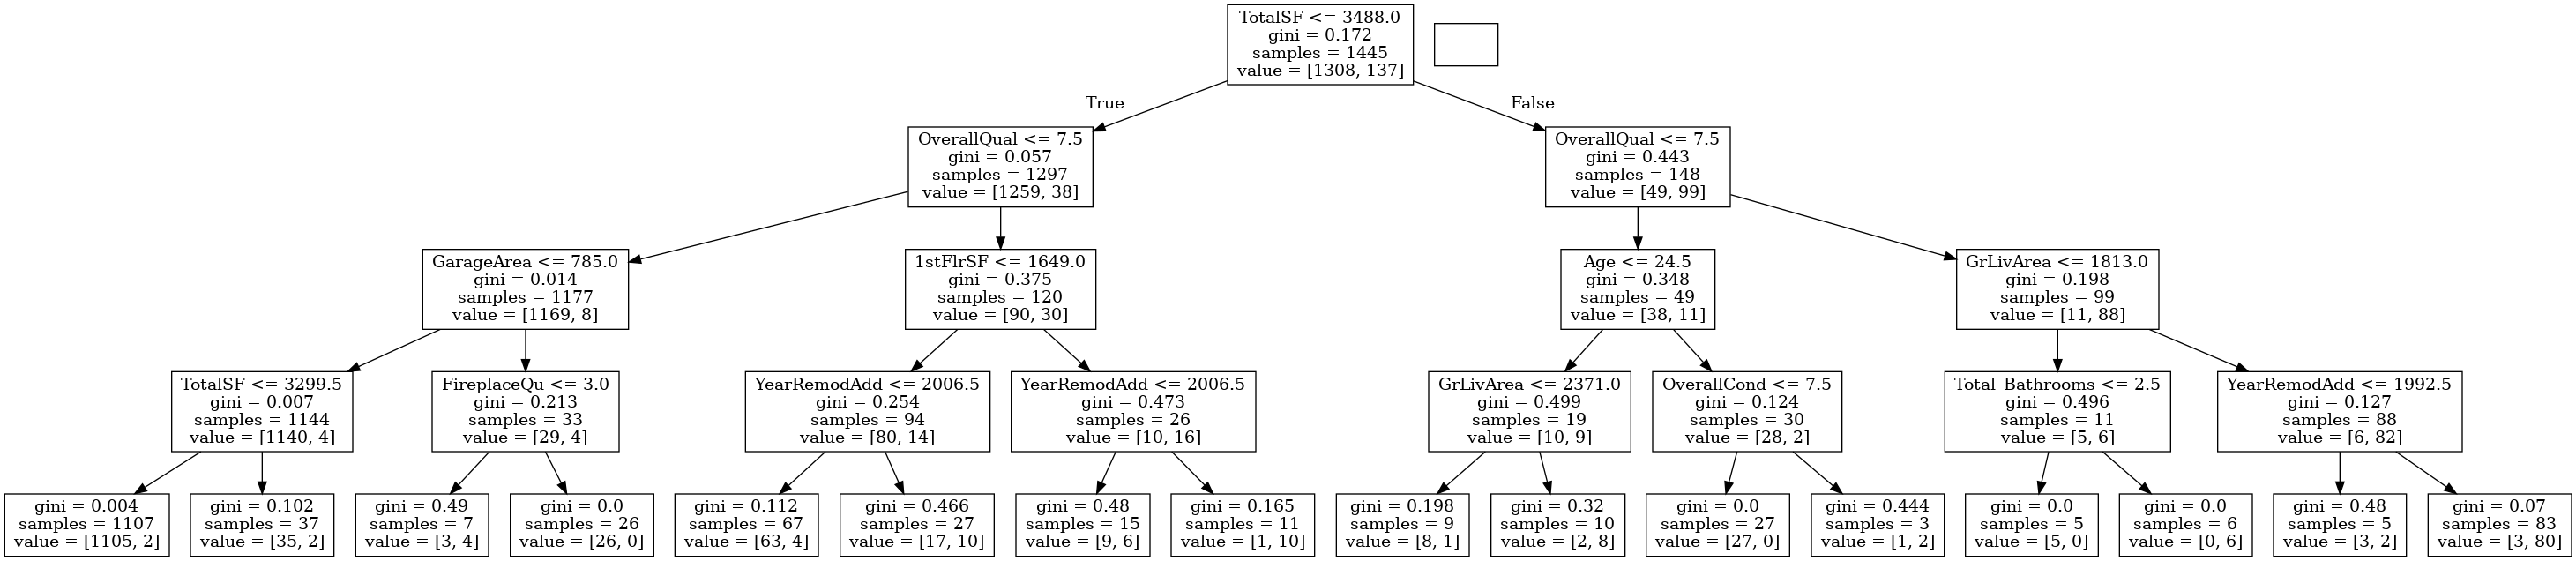

In [9]:
# p.262 4.11 統計手法を用いて家を分類する
# リスト4.95 欠損値のある行を削除する
train_df_le_dn = train_df_le.dropna()
#train_df_le_dn

# p.263 データの正規化を行う
# リスト4.96 データの正規化
from sklearn import preprocessing
train_scaled = preprocessing.scale(train_df_le_dn.drop(["Id"], axis=1))
#train_scaled

# p.264 リスト4.97 np.array形式をDataFrame形式に戻す処理
train_scaled_df = pd.DataFrame(train_scaled)
train_scaled_df.columns = train_df_le_dn.drop(["Id"], axis=1).columns
#train_scaled_df

# p.266 k-means用のライブラリをインポートする
# リスト4.98 k-means用のライブラリのインポート
from sklearn.cluster import KMeans
# リスト4.99 ランダムシードを設定
np.random.seed(1234)

# リスト4.100 クラスタ数を指定して分類
house_cluster = KMeans(n_clusters=4).fit_predict(train_scaled)

# p.267 リスト4.101 家ごとのクラスタ情報を追加
train_scaled_df["km_cluster"] = house_cluster

# リスト4.102 クラスタごとのデータ数を確認
train_scaled_df["km_cluster"].value_counts()

# リスト4.103 クラスタごとの特徴を可視化
cluster_mean = train_scaled_df[["km_cluster", "SalePrice", "TotalSF", "OverallQual", "Age", "Total_Bathrooms", "YearRemodAdd", "GarageArea", "MSZoning", "OverallCond", "KitchenQual", "FireplaceQu"]].groupby("km_cluster").mean().reset_index()

# リスト4.104 転置処理を施して可視化
cluster_mean = cluster_mean.T
#cluster_mean

#cluster_mean[1:].plot(figsize=(12, 10), kind="barh", subplots=True, layout=(1, 4), sharey=True)

# p.271 主成分分析用のライブラリをインポートする
# リスト4.105 PCAパッケージのインポート
from sklearn.decomposition import PCA

# p.272 リスト4.106 主成分の数を指定
pca = PCA(n_components=2)
house_pca = pca.fit(train_scaled).transform(train_scaled)
# house_pca

# p.272 リスト4.107 出力結果をDataFrame形式に変換してもとのDataFrameと結合
house_pca_df = pd.DataFrame(house_pca)
house_pca_df.columns = ["pca1", "pca2"]
train_scaled_df = pd.concat([train_scaled_df, house_pca_df], axis=1)
#train_scaled_df

# p.273 主成分分析の結果を可視化
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#for cl in train_scaled_df['km_cluster'].unique():
#    plt.scatter(train_scaled_df.loc[train_scaled_df["km_cluster"] == cl, 'pca1'], train_scaled_df.loc[train_scaled_df["km_cluster"] == cl, "pca2"], label=cl, c=my_colors[cl], alpha=0.6)
#plt.legend()
#plt.show()

# リスト4.109 見やすいように転置（行と列を変換）
pca_comp_df = pd.DataFrame(pca.components_, columns=train_scaled_df.drop(["km_cluster", "pca1", "pca2"], axis=1).columns).T
pca_comp_df.columns = ["pca1", "pca2"]
#pca_comp_df

# p.276 ハイクラスな家の条件を分析・可視化する
# リスト4.110 SalePriceの分布を確認
#train_df_le['SalePrice'].plot.hist(bins=20)
#train_df_le['SalePrice'].describe()

# p.277 リスト4.111 上位10%の価格を確認
train_df['SalePrice'].quantile(0.9)

# p.278 リスト4.112 high_class変数を追加
train_df_le.loc[train_df["SalePrice"] >= 278000, "high_class"] = 1
# リスト4.113 条件を満たさないものを0とする
train_df_le["high_class"] = train_df_le["high_class"].fillna(0)
train_df_le.head()

# p.281 重要度の高い変数に絞る
# リスト4.116 tree_xとtree_yを指定
tree_x = train_df_le[["TotalSF", "OverallQual", "Age", "GrLivArea", "GarageCars", "Total_Bathrooms", "GarageType", "YearRemodAdd", "GarageArea", "CentralAir", "MSZoning", "OverallCond", "KitchenQual", "FireplaceQu", "1stFlrSF"]]
tree_y = train_df_le[["high_class"]]

# リスト4.117 決定木の作成
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(tree_x, tree_y)

# リスト4.118 決定木の出力結果を確認
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names=tree_x.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
from IPython.display import Image
Image(graph.create_png())